# Mettre en place notre environnement
________

La première chose que nous devons faire est de charger les bibliothèques et les ensembles de données que nous allons utiliser. Pour aujourd'hui, nous allons travailler avec deux ensembles de données : un contenant des chroniques de température dans le lit de la rivière (zone hyporhéique), et un autre contenant des les chroniques de différence de charge enregistré en **Volt**.

**Important!** Assurez-vous d'exécuter cette cellule vous-même ou le reste de votre code ne fonctionnera pas

In [1]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# read in our data
capteur_riviere = pd.read_csv("../../sampling_points/Point034/point034_P_measures.csv",header=1)
capteur_ZH = pd.read_csv("../../sampling_points/Point034/point034_T_measures.csv",header=1)
etalonnage_capteur_riv = pd.read_csv("../../configuration/pressure_sensors/P508.csv")

# set seed for reproducibility
np.random.seed(0)

In [2]:
capteur_riviere["Date Heure, GMT+01:00"] = pd.to_datetime(capteur_riviere["Date Heure, GMT+01:00"])

In [3]:
capteur_ZH["Date Heure, GMT+01:00"] = pd.to_datetime(capteur_ZH["Date Heure, GMT+01:00"])

Nous sommes maintenant prêts à examiner quelques dates ! (Si vous le souhaitez, vous pouvez profiter de cette occasion pour jeter un coup d'œil à certaines des données).

# Imprimez le noms des colonnes
renommer les colonnes du fichier capteur_riviere :  	dates,tension_V,temperature_stream_C et celles du fichier capteur_ZH  :
#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C



In [4]:
# list(capteur_riviere.columns)[-3:]: get the last 3 elements of capteur_riviere.columns

In [4]:
capteur_riviere.drop(labels = list(capteur_riviere.columns)[-3:],axis=1,inplace=True)
capteur_riviere.rename(columns={'#': '#', list(capteur_riviere.columns)[1]: 'dates',list(capteur_riviere.columns)[2]: 'tension_V',
                                list(capteur_riviere.columns)[3]:'temperature_stream_C'}, inplace =  True)


capteur_ZH.drop(labels = list(capteur_ZH.columns)[-3:],axis=1,inplace=True)
capteur_ZH.rename(columns={'#': '#', list(capteur_ZH.columns)[1]: 'dates', list(capteur_ZH.columns)[2]: 'temperature_depth_1_C',
                           list(capteur_ZH.columns)[3]:'temperature_depth_2_C', list(capteur_ZH.columns)[4]:'temperature_depth_3_C',
                           list(capteur_ZH.columns)[5]:'temperature_depth_4_C'}, inplace =  True)
# capteur_ZH.head()
capteur_riviere.head()

,#,dates,tension_V,temperature_stream_C
0,1.0,2016-06-27 12:00:00,1.26787,18.342
1,2.0,2016-06-27 12:15:00,1.06630,13.898
2,3.0,2016-06-27 12:30:00,1.20661,13.915
3,4.0,2016-06-27 12:45:00,1.24533,13.939
4,5.0,2016-06-27 13:00:00,1.24437,13.967


# Transformez les données de différence de charge en mètres



In [6]:
# etalonnage_capteur_riv.iloc[2] : the third row(indexed 2) of etalonnage_capteur_riv
# list(etalonnage_capteur_riv.columns)[-1] : just the string 'P508'

In [5]:
intercept = float(etalonnage_capteur_riv.iloc[2][list(etalonnage_capteur_riv.columns)[-1]])
dUdH = float(etalonnage_capteur_riv.iloc[3][list(etalonnage_capteur_riv.columns)[-1]])
dUdT = float(etalonnage_capteur_riv.iloc[4][list(etalonnage_capteur_riv.columns)[-1]])
capteur_riviere["charge_m"] = (capteur_riviere["tension_V"]-capteur_riviere["temperature_stream_C"]*dUdT-intercept)/dUdH
capteur_riviere.head()
# charge_m = (tens_V-temp_C·dU/dT-Intercept)/(dU/dH)
# df["a*b"] = df["a"] * df["b"]

,#,dates,tension_V,temperature_stream_C,charge_m
0,1.0,2016-06-27 12:00:00,1.26787,18.342,-0.020848
1,2.0,2016-06-27 12:15:00,1.06630,13.898,0.112499
2,3.0,2016-06-27 12:30:00,1.20661,13.915,0.016578
3,4.0,2016-06-27 12:45:00,1.24533,13.939,-0.009873
4,5.0,2016-06-27 13:00:00,1.24437,13.967,-0.009189


# Traitement des dates
## Vérifiez le type de données de notre colonne de date
___

Imprimer les dates des deux fichiers

In [39]:
capteur_riviere['dates']
capteur_ZH['dates']

,#,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C
0,1,2016-06-27 12:00:00,13.810,13.834,13.858,13.810
1,2,2016-06-27 12:15:00,13.834,13.858,13.882,13.834
2,3,2016-06-27 12:30:00,13.930,13.954,14.050,14.002
3,4,2016-06-27 12:45:00,13.882,13.954,14.026,13.954
4,5,2016-06-27 13:00:00,13.858,13.930,14.026,13.954
...,...,...,...,...,...,...
1433,1434,2016-07-12 10:15:00,14.457,14.697,14.792,14.649
1434,1435,2016-07-12 10:30:00,15.008,14.792,14.816,14.649
1435,1436,2016-07-12 10:45:00,17.320,17.296,17.034,17.130
1436,1437,2016-07-12 10:49:31,NaN,NaN,NaN,NaN


Remarquez qu'en bas de la sortie de `head()`, vous pouvez voir qu'il est dit que le type de données de cette colonne est "object". 

> Pandas utilise le dtype "object" pour stocker différents types de données, mais le plus souvent, lorsque vous voyez une colonne avec le dtype "object", elle contient des chaînes de caractères. 

Si vous consultez la documentation sur le dtype de Pandas [ici] (http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes), vous remarquerez qu'il existe également un dtype spécifique `datetime64`. Comme le dtype de notre colonne est `object` plutôt que `datetime64`, nous pouvons dire que Python ne sait pas que cette colonne contient des dates.

Nous pouvons aussi regarder uniquement le dtype de votre colonne sans imprimer les premières lignes si nous le souhaitons :

In [7]:
# check the data type of our date column
print(type(capteur_riviere['dates'].dtypes))

<class 'numpy.dtype[datetime64]'>


In [8]:
print(type(capteur_ZH['dates'].dtypes))

<class 'numpy.dtype[datetime64]'>


You may have to check the [numpy documentation](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) to match the letter code to the dtype of the object. "O" is the code for "object", so we can see that these two methods give us the same information.

## Convertir nos colonnes de date en datetime
___

Maintenant que nous savons que notre colonne de date n'est pas reconnue comme une date, il est temps de la convertir pour qu'elle soit reconnue comme une date. Cette opération est appelée "analyse syntaxique des dates" car nous prenons une chaîne de caractères et identifions ses composants. Nous allons utiliser la fonction pd.to_datetime.

Nous pouvons indiquer à pandas le format de nos dates à l'aide d'un guide appelé ["strftime directive", sur lequel vous trouverez plus d'informations à ce lien] (http://strftime.org/). L'idée de base est que vous devez indiquer quelles parties de la date se trouvent où et quelle ponctuation se trouve entre elles. Il existe [de nombreuses parties possibles d'une date](http://strftime.org/), mais les plus courantes sont `%d` pour le jour, `%m` pour le mois, `%y` pour une année à deux chiffres et `%Y` pour une année à quatre chiffres.

Quelques exemples :

 * Le 17 janvier 2007 a le format "%m/%d/%y".
 * 17-1-2007 a le format "%d-%m-%Y".
 

In [9]:
capteur_riviere['dates'] = pd.to_datetime(capteur_riviere['dates'], infer_datetime_format=True)
capteur_ZH['dates'] = pd.to_datetime(capteur_ZH['dates'], infer_datetime_format=True)
print(type(capteur_riviere['dates'].dtypes))
print(type(capteur_ZH['dates'].dtypes))

<class 'numpy.dtype[datetime64]'>
<class 'numpy.dtype[datetime64]'>


Maintenant que nos dates sont analysées correctement, nous pouvons travailler avec celles-ci.

___
* Bien que nous spécifions le format de la date ici, il arrive parfois que vous rencontriez une erreur lorsque plusieurs formats de date sont présents dans une même colonne. Dans ce cas, vous pouvez demander à pandas de déduire le bon format de date. Vous pouvez le faire comme suit :

`capteur_riviere['date'] = pd.to_datetime(capteur_riviere['date'], infer_datetime_format=True)``

**Pourquoi ne pas toujours utiliser `infer_datetime_format = True?`** Il y a deux grandes raisons de ne pas toujours faire deviner à pandas le format de l'heure. La première est que pandas n'est toujours capable de trouver le bon format de date, surtout si quelqu'un a fait preuve de créativité dans la saisie des données. La seconde est que c'est beaucoup plus lent que de spécifier le format exact des dates.
____

## Tracer le jour du mois pour vérifier l'analyse de la date
___

L'un des plus grands dangers de l'analyse des dates est de mélanger les mois et les jours. La fonction to_datetime() a des messages d'erreur très utiles, mais il n'est pas inutile de vérifier que les jours du mois que nous avons extraits ont un sens. 

Pour ce faire, nous allons tracer un histogramme des jours du mois. Nous nous attendons à ce qu'il ait des valeurs entre 1 et 31 et, puisqu'il n'y a aucune raison de supposer que les glissements de terrain sont plus fréquents certains jours du mois que d'autres, une distribution relativement égale. (Avec un creux sur 31 car tous les mois n'ont pas 31 jours.) 

In [27]:
list(capteur_ZH.columns)

['#',
 'dates',
 'temperature_depth_1_C',
 'temperature_depth_2_C',
 'temperature_depth_3_C',
 'temperature_depth_4_C']

(array([96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 96., 68.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        48., 96., 96., 96.,  0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32.]),
 <BarContainer object of 31 artists>)

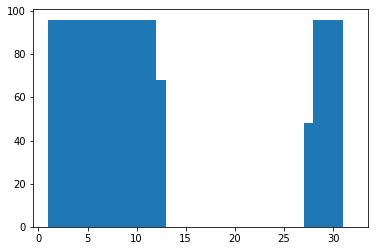

In [11]:
days = capteur_riviere["dates"].dt.day
plt.hist(days,range=[1,32],bins=31)

In [12]:
df = pd.DataFrame(days)
df.value_counts()

dates
1        96
2        96
3        96
4        96
5        96
6        96
7        96
8        96
9        96
10       96
11       96
28       96
29       96
30       96
12       68
27       48
dtype: int64

# Valeurs aberrantes(离群值/outlier)

<b>L'un des plus grands défis du nettoyage des données est l'identification et le traitement des valeurs aberrantes.</b> En termes simples, les valeurs aberrantes sont des observations qui sont significativement différentes des autres points de données. Même les meilleurs algorithmes d'estimation des paramètres automatique seront moins performants si les observations aberrantes ne sont pas nettoyées des données, car elles impliquent des simulations obsolètes des variables.



## Identification des valeurs aberrantes

La présence de valeurs aberrantes dans les données peut avoir de nombreuses raisons. Parfois, les valeurs aberrantes peuvent être authentiques, alors que dans d'autres cas, elles peuvent être dues à des erreurs de saisie de données. Il est important de comprendre les raisons des valeurs aberrantes avant de les nettoyer.

Nous allons commencer le processus de recherche des valeurs aberrantes en exécutant les statistiques sommaires sur les variables. Pour ce faire, nous utilisons la fonction describe() ci-dessous, qui fournit un résumé statistique de toutes les variables quantitatives.




## Tracez les graphiques de distribution pour les différentes variables

#### 1. Box plot

Le box plot est une manière standardisée d'afficher la distribution des données sur la base du résumé en cinq chiffres (minimum, premier quartile (Q1), médiane, troisième quartile (Q3) et maximum). Elle est souvent utilisée pour identifier la distribution des données et détecter les valeurs aberrantes. La ligne de code ci-dessous trace le box plot de la variable numérique 'Loan_amount'. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f95f116c250>,
 'caps': [<matplotlib.lines.Line2D at 0x7f95f116c7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f95f1180640>],
 'medians': [<matplotlib.lines.Line2D at 0x7f95f116cd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f95f11980a0>],
 'means': []}

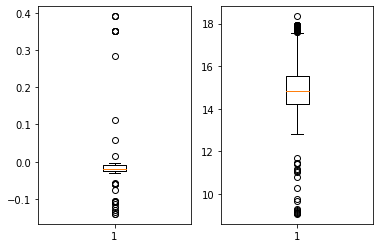

In [21]:
fig, axs = plt.subplots(1,2)
axs[0].boxplot(capteur_riviere["charge_m"])
axs[1].boxplot(capteur_riviere["temperature_stream_C"])

## 2. Histogramme

Un histogramme est utilisé pour visualiser la distribution d'une variable numérique. Une valeur aberrante apparaît en dehors du modèle général de distribution. La ligne de code ci-dessous trace un histogramme de la variable 'Revenu', en utilisant la fonction hist(). A histogram is used to visualize the distribution of a numerical variable. An outlier will appear outside the overall pattern of distribution. The line of code below plots a histogram of the 'Income' variable, using the hist() function. 

## 3. Scatterplot

Un nuage de points permet de visualiser la relation entre deux variables quantitatives. Les données sont affichées sous la forme d'une collection de points, et tout point qui ne correspond pas au regroupement général des deux variables peut indiquer des valeurs aberrantes. 

génèrez un nuage de points entre les différentes variables de températures. 



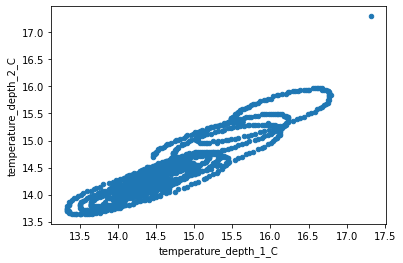

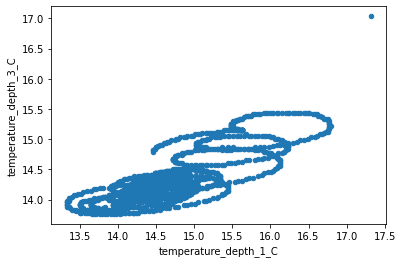

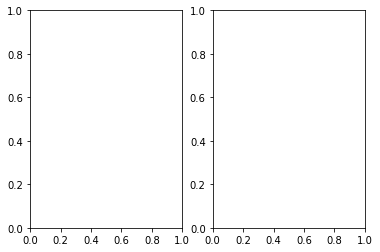

In [38]:
ax1 = capteur_ZH.plot.scatter(x="temperature_depth_1_C",y="temperature_depth_2_C")
ax2 = capteur_ZH.plot.scatter(x="temperature_depth_1_C",y="temperature_depth_3_C")
# capteur_ZH.plot.scatter(x="temperature_depth_1_C",y="temperature_depth_4_C")
# capteur_ZH.plot.scatter(x="temperature_depth_2_C",y="temperature_depth_3_C")
# capteur_ZH.plot.scatter(x="temperature_depth_2_C",y="temperature_depth_4_C")
# capteur_ZH.plot.scatter(x="temperature_depth_3_C",y="temperature_depth_4_C")
fig, axs = plt.subplots(1,2)
axs[0] = ax1
axs[1] = ax2

# Identification des valeurs aberrantes avec l'écart interquartile (IQR)

L'écart interquartile (IQR) est une mesure de la dispersion statistique et est calculé comme la différence entre les 75e et 25e percentiles. Il est représenté par la formule IQR = Q3 - Q1. Les  lignes de code ci-dessous calculent et impriment l'écart interquartile pour chacune des variables de l'ensemble de données.  La règle générale est que tout ce qui n'est pas dans la plage de (Q1 - 1,5 IQR) et (Q3 + 1,5 IQR) est une valeur aberrante et peut être supprimé.


### Fonctions d'assistance

Ecrire des fonctions afin d'examiner chaque colonne des deux fichiers de données de terain et de calculer les 1er et 3e quartiles, l'intervalle inter-quartile et le minimum et le maximum. Toute valeur en dehors du minimum et du maximum est une valeur aberrante.

0.9809999999999999


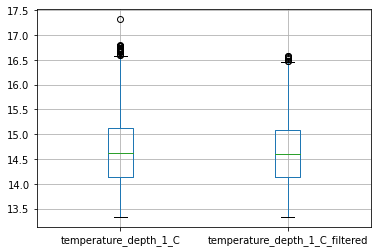

In [76]:
var = "temperature_depth_1_C"
data = capteur_ZH
def remove_outliers(data, var):
    Q1 = capteur_ZH[var].quantile(0.25)
    Q3 = capteur_ZH[var].quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    text = "(@Q1 - 1.5 * @IQR) <="+var+"  <= (@Q3 + 1.5 * @IQR)"
    # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
    filtered = pd.DataFrame(data[var]).query(text)
    data[var+"_filtered"] = filtered
    data.boxplot(column=[var,var+"_filtered"])
remove_outliers(data,var)


### Résolution de la distribution asymétrique…

A partir de nos données dans un histogramme, nous pouvons obtenir une distribution asymétrique des données. Une seule grande barre avec de minuscules barres à gauche ou à droite (ou les deux) est un signe révélateur que des valeurs aberrantes peuvent être présentes dans les données et cela signifie que notre bel histogramme, bien rangé et normalement distribué, est complètement caché et obscurci par le seul grand bar.


Lorsque nous observons ce modèle, nous devons supprimer les valeurs aberrantes, puis voir à quoi ressemble la nouvelle distribution. Si nous voulons vérifier la présence de valeurs aberrantes, une boîte à moustaches rapide confirmera ou refusera…

## Suppression des valeurs aberrantes et visualisation du résultat

Après avoir fait tout le gros du travail dans les fonctions d'assistance, nous pouvons maintenant supprimer les lignes des données qui contiennent des valeurs aberrantes en dehors de | - et - | moustaches…

## Expliquez le résultat
est ce que cette méthodologie vous semble suffisante? Tentez de trouver les limites de cette méthodologie?
Que pouvez vous apportez aux fonctions afin de les améliorer?

## Valeurs abérantes avec la méthode score Z 
Il s'agit d'une unité mesurée en écart-type. Fondamentalement, il s'agit d'une mesure de la distance entre le score brut et la moyenne. Il est compris entre -3 et +3, où 0 = moyenne et 1 = écart-type, c'est-à-dire une distribution normale.

Cette méthode suggère qu'en tout point de données il existe une relation entre l'écart-type et la moyenne. Le score Z permet de trouver la distribution des données où la moyenne est égale à 0 et l'écart-type à 1, c'est-à-dire une distribution normale. Vous devez vous demander en quoi cela peut nous aider à identifier les valeurs aberrantes ? En calculant le score Z, nous redimensionnons et centrons les données et recherchons les points de données qui sont trop éloignés de zéro. Ces points de données qui sont trop éloignés de zéro seront traités comme des valeurs aberrantes. Dans la plupart des cas, un seuil de 3 ou -3 est utilisé, c'est-à-dire que si la valeur du score Z est supérieure ou inférieure à 3 ou -3 respectivement, ce point de données sera identifié comme aberrant.

Formule pour le score Z = (Observation - Moyenne)/Écart-type

z = (X - μ) / σ

Ecrire des functions afin de pouvoir appliquer cette méthodologie aux données

## Comparer les deux méthodologies, donner leurs avantages et leurs limitations
Vous pouvez proposer des alternatives.

## Proposer une fonction permettant d'aller des données brutes jusqu'au premier traitement des données.

N'oubliez pas de permettre à l'utilisateur de pouvoir prendre des décisions et de l'aider à prendre ces décisions
Pensez à indiquer à l'utilisateur si le jeu de données est utilisable, quels sont les capteurs défaillant, quel semble être l'orientation des échanges nappe-rivière, les données de différence de charge semblent t'elles données les mêmes informations que les données du profils de température.

Votre function doit prendre en entrée, les trois fichiers et proposer au fur et à mesure de son dérouler des propositions à l'utilisateur.

# Deux autres jeux de données sont disponibles sur le répertoire github.
Votre rôle est de traiter et d'analyser ces données avec la méthodologie que vous avez développé

## Trouver les valeurs limites

In [15]:
capteur_riviere[["tension_V","temperature_stream_C"]].describe()

,tension_V,temperature_stream_C
count,1460.000000,1460.000000
mean,1.256888,14.896441
std,0.047302,1.142397
min,0.652670,9.066000
25%,1.246590,14.203750
50%,1.262150,14.818000
75%,1.270010,15.555000
max,1.432100,18.342000


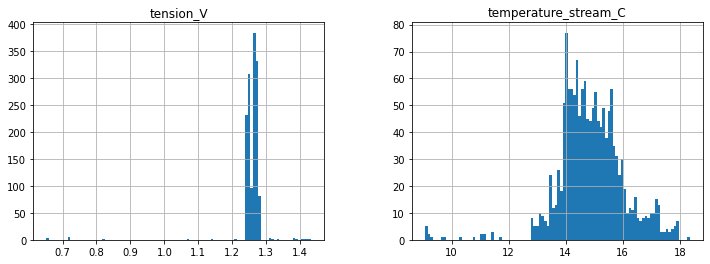

In [16]:
capteur_riviere[["tension_V","temperature_stream_C"]].hist(bins=100,figsize=(12,4),layout=(1,2))
plt.show()

In [17]:
capteur_ZH[["temperature_depth_1_C","temperature_depth_2_C","temperature_depth_3_C"]].describe()

,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C
count,1436.000000,1436.000000,1436.000000
mean,14.717557,14.502795,14.348946
std,0.721799,0.531472,0.423288
min,13.329000,13.642000,13.762000
25%,14.146000,14.098000,14.050000
50%,14.625000,14.409000,14.242000
75%,15.127000,14.768000,14.505000
max,17.320000,17.296000,17.034000


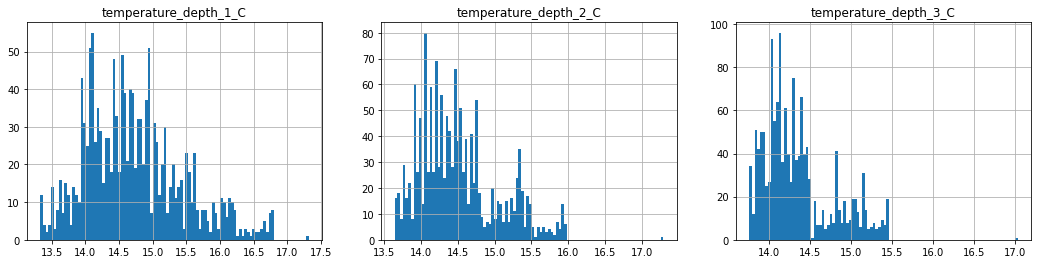

In [18]:
capteur_ZH[["temperature_depth_1_C","temperature_depth_2_C","temperature_depth_3_C"]].hist(bins=100,figsize=(18,4),layout=(1,3))
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.show()